--- Step 1: Installing Environment (Skips if already installed) ---
--- Step 2: Verify Data ---
Data is ready (or archive not found, attempting to read directory directly).
--- Step 3: Setup Data and Model ---


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Step 4: Start Training and Inference ---


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor  │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator     │      0 │ train │     0 │
│ 3 │ model          │ PadimModel    │  2.8 M │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 69                                                                                           
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 69 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9984126687049866     │
│       image_F1Score       │    0.9841269850730896     │
│        pixel_AUROC        │    0.9818966388702393     │
│       pixel_F1Score       │    0.6974756121635437     │
└───────────────────────────┴───────────────────────────┘

--- Step 5: Search and Display Results ---
[Success] Found 63 result images. Showing 2 of them:


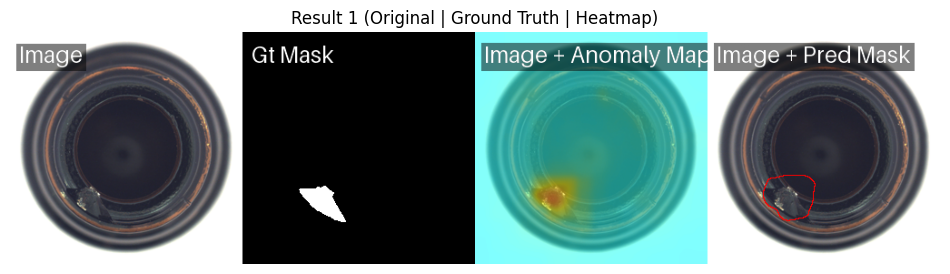

Image path: ./results/Padim/MVTecAD/bottle/latest/images/broken_small/005.png


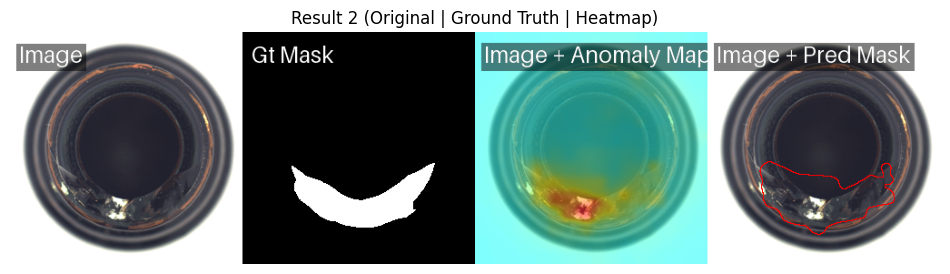

Image path: ./results/Padim/MVTecAD/bottle/latest/images/broken_small/012.png

[Done] Total time: 31 seconds


In [ ]:
# Environment Setup
import time
start_time = time.time()

print("--- Step 1: Installing Environment (Skips if already installed) ---")
# Added this line to ensure Anomalib is installed
!pip install anomalib lightning -q

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from anomalib.data import MVTecAD
from anomalib.models import Padim
from anomalib.engine import Engine


# 1. Decompression (Skips if previously extracted)

print("--- Step 2: Verify Data ---")
source_file = "/content/bottle.tar.xz"
target_dir = "./datasets/MVTec"

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# Only extract if the directory is empty to save time
if os.path.exists(source_file) and not os.path.exists(os.path.join(target_dir, "bottle")):
    print("Extracting...")
    os.system(f'tar -xf "{source_file}" -C "{target_dir}"')
else:
    print("Data is ready (or archive not found, attempting to read directory directly).")


# 2. Load Data and Model

print("--- Step 3: Setup Data and Model ---")

datamodule = MVTecAD(
    root=target_dir,
    category="bottle",
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=2
)
datamodule.prepare_data()
datamodule.setup()

model = Padim()


# 3. Training and Testing

print("--- Step 4: Start Training and Inference ---")

engine = Engine(
    accelerator="auto",
    devices=1,
    default_root_dir="./results"
)

# Train
engine.fit(model=model, datamodule=datamodule)
# Test
engine.test(model=model, datamodule=datamodule)


# 4. Show Results

print("--- Step 5: Search and Display Results ---")

def find_and_show_results():
    base_path = "./results"
    all_images = glob.glob(f"{base_path}/**/*.png", recursive=True)

    # Strict filter: Find "prediction heatmaps" in the "test set"
    # Usually the path contains 'test' and excludes 'good' (non-defective)
    defect_images = [
        img for img in all_images
        if "good" not in img and "ground_truth" not in img and "test" in img
    ]

    # If not found, relax conditions to find any heatmap
    if not defect_images:
        defect_images = [img for img in all_images if "heatmap" in img and "good" not in img]

    if defect_images:
        print(f"[Success] Found {len(defect_images)} result images. Showing 2 of them:")
        # Show the top 2 images
        for i, img_path in enumerate(defect_images[:2]):
            img = mpimg.imread(img_path)
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Result {i+1} (Original | Ground Truth | Heatmap)", fontsize=12)
            plt.show()
            print(f"Image path: {img_path}")
    else:
        print("[Hint] No result images found. Please manually check the ./results folder.")

find_and_show_results()

end_time = time.time()
print(f"\n[Done] Total time: {int(end_time - start_time)} seconds")